In [1]:
from tqdm.autonotebook import tqdm

/home/calsaverini/.venvs/survival/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [5]:
import pandas as pd
import numpy as np
import pycm

from xgboost import XGBClassifier
from sklearn import metrics as skmetrics
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.preprocessing import label_binarize, QuantileTransformer
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
import logging

/home/calsaverini/.venvs/survival/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [7]:
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline

In [9]:
raw_features = pd.read_parquet("./raw_features.parquet")
categorical_columns = ['partner', 'device', 'gender', 'state', 'channel']
feature_columns = [
    'channel', 'partner', 'device', 'age', 'gender', 'state', 'has_marketplace', 
    'has_crossdocking', 'has_private_label', 'has_brands', 'gmv', 'fst_sale_in_black_friday_days'
]

In [5]:
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)
df = df.loc[df.waiting_time > 0]

In [6]:
# df.has_second_sale_within_year = (df.waiting_time < (15)).astype(int)

In [7]:
features = [c for c in df.columns if any([c.startswith(x) for x in feature_columns])]
X = df.loc[:, features]
y = df.loc[:, 'has_second_sale_within_year']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

qt = QuantileTransformer()
qt.fit(X_train.loc[:, ["age", "gmv"]])

X_train.loc[:, ["age", "gmv"]] = qt.transform(X_train.loc[:, ["age", "gmv"]])
X_test.loc[:, ["age", "gmv"]] = qt.transform(X_test.loc[:, ["age", "gmv"]])

/home/calsaverini/.venvs/sandbox/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/calsaverini/.venvs/sandbox/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [9]:
HYPERPARAMETER_SPACE = [
    Integer(1, 10, name='min_child_weight'),
    Real(1e-5, 1.0, "uniform", name='learning_rate'),
    Real(0.1, 10, "log-uniform", name='gamma'),    
    Real(0.05, 1, name='subsample'),
    Real(0.05, 1, name='colsample_bytree'),
#     Integer(2, 6, name='max_depth'),
#     Integer(100, 200, name="n_estimators"),
    Real(0.01, 0.99, name="base_score"),
#     Real(0.9, 1,0, name="scale_pos_weight"),
    Real(0, 5, name="reg_alpha"),
    Real(0, 5, name="reg_lambda"),
]

HYPERPARAMETER_NAMES = [dim.name for dim in HYPERPARAMETER_SPACE]

In [10]:
RANDOM_STATE = 939568576
TREE_METHOD = 'hist'#'exact'
NUM_PROCESSORS = 8
NUM_CROSS_VALIDATION_STEPS = 1
NUM_GP_OPTIMIZATION_STEPS = 1

In [11]:
def get_logger(name):
    logger = logging.getLogger(name)
    formatter = logging.Formatter('[%(asctime)s] %(message)s')
    stream_handler = logging.StreamHandler()
    stream_handler.setFormatter(formatter)
    logger.addHandler(stream_handler)
    logger.setLevel(logging.INFO)
    return logger

logger = get_logger(__name__)

In [12]:
def train_model(X, y, **kwargs):
    model = XGBClassifier(
        max_depth=5,
        n_estimators=1000,
        scale_pos_weight=1,
        random_state=RANDOM_STATE,
        tree_method=TREE_METHOD,
        n_jobs=NUM_PROCESSORS,
        **kwargs,
    )
    model.fit(X, y)
    return model

def evaluate_model(X, y, **kwargs):
    roc_auc = []
    for _ in range(NUM_CROSS_VALIDATION_STEPS):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
        model = train_model(X_train, y_train, **kwargs)
        score = model.predict_proba(X_test)
        #total_correlation = np.sqrt(1 - np.exp(-2 * mutual_info_classif(score, y_test)))
        log_like = np.log(score[range(y_test.size), y_test]).mean()
        roc_auc.append(log_like)
    logger.info(f"Values: {roc_auc}")
    return np.mean(roc_auc)


def train_optimized_model(X, y):
        
    @use_named_args(HYPERPARAMETER_SPACE)
    def loss(**kwargs):
        return -evaluate_model(X, y, **kwargs)

    def get_optimization_callback():
        message = "Hyperparameter optimization iteration {:d}/{:d}. Current: {:5.3f}. Best: {:5.3f}."
            #" Parameters:\n{}"
        def callback(res):          
            current_value = -res.func_vals[-1]
            best_value = -res.func_vals.min()            
            current_params = pd.Series(dict(zip(
                HYPERPARAMETER_NAMES, 
                map(fix_type, res.x)
            )))
            logger.info(message.format(
                len(res.func_vals),
                NUM_GP_OPTIMIZATION_STEPS,
                current_value,
                best_value,
                #current_params
            ))

        return callback

    def fix_type(x):
        if isinstance(x, bool):
            return x
        elif np.issubdtype(np.dtype(x), np.int_):
            return int(x)
        elif np.issubdtype(np.dtype(x), np.float_):
            return float(x)

    logger.info("Will start hyperparameter optimization.")
    optimization_results = gp_minimize(
        loss,
        HYPERPARAMETER_SPACE,
        n_random_starts=max(1, min(10, int(NUM_GP_OPTIMIZATION_STEPS / 2))),
        n_calls=NUM_GP_OPTIMIZATION_STEPS,
        random_state=RANDOM_STATE,
        callback=get_optimization_callback(),
    )
    logger.info("Finished hyperparameter optimization.")
    best_parameters = dict(
        zip(HYPERPARAMETER_NAMES, map(fix_type, optimization_results.x))
    )
    logger.info("Starting training of final model.")
    return train_model(X, y, verbosity=1, **best_parameters)


In [13]:
%time best_model = train_optimized_model(X_train, y_train)

[2019-05-09 14:52:39,197] Will start hyperparameter optimization.
[2019-05-09 14:55:29,026] Values: [-0.3719047]
[2019-05-09 14:55:29,277] Hyperparameter optimization iteration 1/1. Current: -0.372. Best: -0.372.
[2019-05-09 14:55:29,278] Finished hyperparameter optimization.
[2019-05-09 14:55:29,278] Starting training of final model.


CPU times: user 44min 20s, sys: 8.64 s, total: 44min 29s
Wall time: 6min 4s


In [14]:
y_pred = best_model.predict(X_test)
s_pred = best_model.predict_proba(X_test)

print(skmetrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.97      0.90    275444
           1       0.83      0.46      0.59     92804

   micro avg       0.84      0.84      0.84    368248
   macro avg       0.84      0.72      0.75    368248
weighted avg       0.84      0.84      0.82    368248



In [15]:
cm = pycm.ConfusionMatrix(actual_vector=y_test.values, predict_vector=y_pred)
cm.print_normalized_matrix()

Predict       0             1             
Actual
0             0.96929       0.03071       

1             0.53927       0.46073       




In [16]:
fpr, tpr, roc_thres = skmetrics.roc_curve(y_test, s_pred[:, 1])

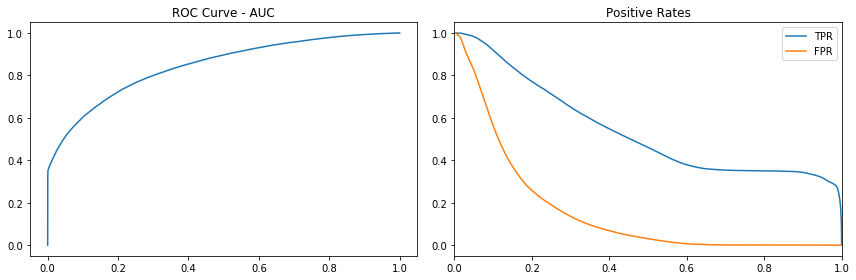

In [25]:
fig = plt.figure(figsize=(12, 4))

ax = fig.add_subplot(121)
ax.set_title(f"ROC Curve - AUC")
ax.plot(fpr, tpr)

ax = fig.add_subplot(122)
ax.set_title("Positive Rates")
ax.plot(roc_thres, tpr, label="TPR")
ax.plot(roc_thres, fpr, label="FPR")
ax.set_xlim(0, 1)
ax.legend()

fig.tight_layout()

In [18]:
total_correlation = np.sqrt(1 - np.exp(-2 * mutual_info_classif(s_pred, y_test))).min()
print(total_correlation)

0.567342662696918


In [19]:
skmetrics.roc_auc_score(label_binarize(y_test, range(len(code2period))), s_pred, average='micro')

NameError: name 'code2period' is not defined

In [20]:
skmetrics.roc_auc_score(label_binarize(y_test, range(len(code2period))), s_pred, average='macro')

NameError: name 'code2period' is not defined

In [21]:
n_points = min(100, np.unique(s_pred[:, 1]).shape[0])

In [22]:
thresholds = np.linspace(s_pred.min(), s_pred[:, 1].max()*0.999, n_points)

metrics = pd.DataFrame([
    skmetrics.precision_recall_fscore_support(y_test, (s_pred[:, 1] >= threshold), average='binary')
    for threshold in thresholds
], columns=["precision", "recall", "f1", "support"], index=thresholds)

optimal_threshold = metrics.f1.idxmax()


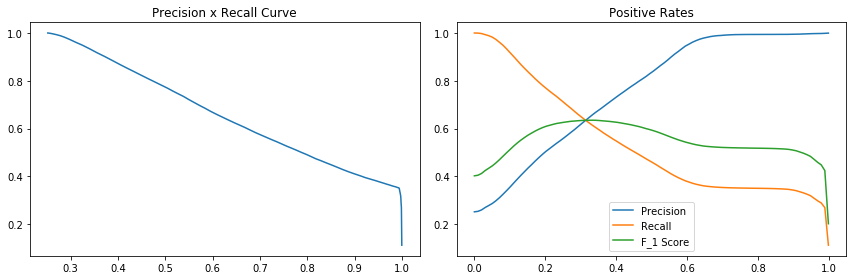

In [26]:
fig = plt.figure(figsize=(12, 4))

ax = fig.add_subplot(121)
ax.set_title("Precision x Recall Curve")
ax.plot(metrics.precision, metrics.recall)

ax = fig.add_subplot(122)
ax.set_title("Positive Rates")
ax.plot(metrics.index, metrics.precision, label="Precision")
ax.plot(metrics.index, metrics.recall, label="Recall")
ax.plot(metrics.index, metrics.f1, label="F_1 Score")
# ax.axvline(optimal_threshold)
ax.legend()

fig.tight_layout()

In [81]:
optimal_threshold = metrics.f1.argmax()
print(metrics.loc[optimal_threshold])
y_pred = (s_pred[:, 1] > 0.45).astype(int)

precision    0.657667
recall       0.614198
f1           0.635189
support          None
Name: 0.3330003182093303, dtype: object


/home/calsaverini/.venvs/sandbox/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  """Entry point for launching an IPython kernel.


In [82]:
print(skmetrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.95      0.90    275444
           1       0.78      0.50      0.61     92804

   micro avg       0.84      0.84      0.84    368248
   macro avg       0.82      0.73      0.76    368248
weighted avg       0.83      0.84      0.83    368248



In [ ]:
#best_model.save_artifact("./within_year_model.pred")

In [ ]:
pd.Series(dict(zip(X.columns, best_model.feature_importances_))).sort_values(ascending=False).head(20)

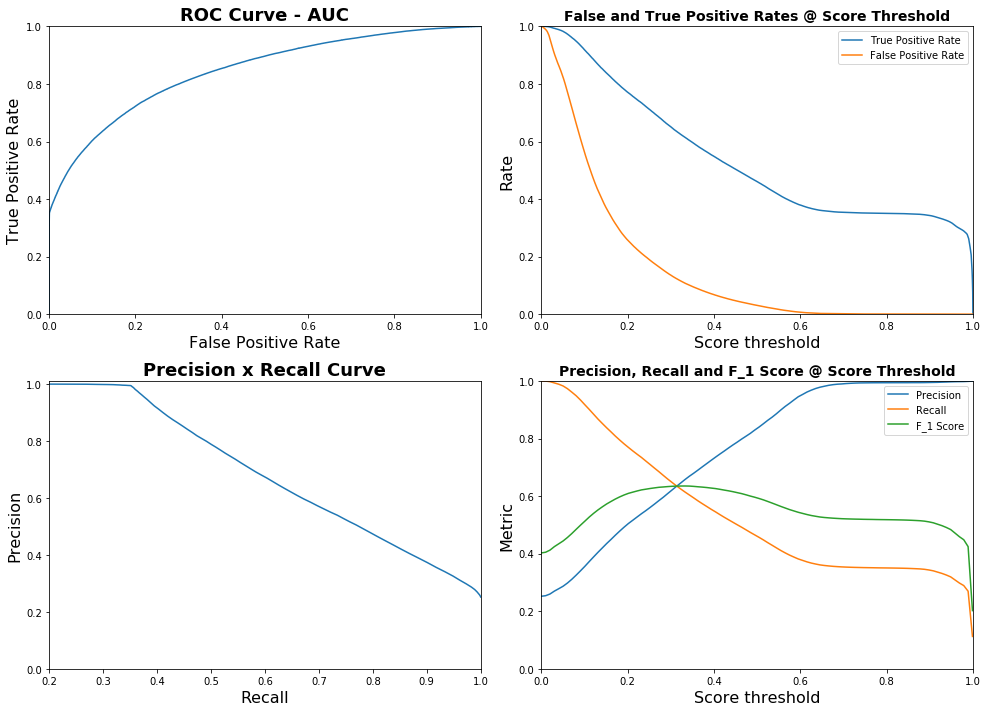

In [64]:
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(221)
ax.set_title(f"ROC Curve - AUC", fontdict={'size': 18, 'fontweight': 'bold'})
ax.plot(fpr, tpr)
ax.set_xlabel("False Positive Rate", fontdict={'size': 16})
ax.set_ylabel("True Positive Rate", fontdict={'size': 16})
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

ax = fig.add_subplot(222)
ax.set_title("False and True Positive Rates @ Score Threshold", fontdict={'size': 14, 'fontweight': 'bold'})
ax.plot(roc_thres, tpr, label="True Positive Rate")
ax.plot(roc_thres, fpr, label="False Positive Rate")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel("Score threshold", fontdict={'size': 16})
ax.set_ylabel("Rate", fontdict={'size': 16})
ax.legend()

ax = fig.add_subplot(223)
ax.set_title("Precision x Recall Curve", fontdict={'size': 18, 'fontweight': 'bold'})
ax.plot(metrics.recall, metrics.precision)
ax.set_xlabel("Recall", fontdict={'size': 16})
ax.set_ylabel("Precision", fontdict={'size': 16})
ax.set_xlim(0.2, 1)
ax.set_ylim(0, 1.01)


ax = fig.add_subplot(224)
ax.set_title("Precision, Recall and F_1 Score @ Score Threshold", fontdict={'size': 14, 'fontweight': 'bold'})
ax.plot(metrics.index, metrics.precision, label="Precision")
ax.plot(metrics.index, metrics.recall, label="Recall")
ax.plot(metrics.index, metrics.f1, label="F_1 Score")
ax.set_xlabel("Score threshold", fontdict={'size': 16})
ax.set_ylabel("Metric", fontdict={'size': 16})
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.legend()

fig.tight_layout()

In [ ]:
fig.s